In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import sys
import os
import numpy as np
import pandas as pd
import scipy.sparse
from scipy.sparse import csc_matrix
from scipy.sparse import lil_matrix

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Circle
import seaborn as sns; 
from IPython.display import HTML

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn import svm
from sklearn.metrics import r2_score

In [3]:
#config parser
import configparser

sys.path.insert(0, '../Common/')
from AISDataManager import AISDataManager
import Constants as c
import HMUtils as hMUtil
import TimeUtils as timeUtils
import GeoCompute as gC

#MyConfig.INI stores all the run time constants
config = configparser.ConfigParser()
config.read('../MyConfig.INI')

from joblib import Parallel, delayed
import multiprocessing
aISDM = AISDataManager()
numCores = multiprocessing.cpu_count()

In [4]:
lonMin = (float)(config['TP_SEC_ORDER']['LON_MIN'])
lonMax = (float)(config['TP_SEC_ORDER']['LON_MAX'])

latMin = (float)(config['TP_SEC_ORDER']['LAT_MIN'])
latMax = (float)(config['TP_SEC_ORDER']['LAT_MAX'])

print(lonMin,latMin)
print(lonMax,latMax)

increStep = (float)(config['TP_SEC_ORDER']['INCR_STEP'])
incrRes = (int)(config['TP_SEC_ORDER']['INCR_RES'])

fileDir = config['TP_SEC_ORDER']['SOURCE_DIR']
dirToStore = config['TP_SEC_ORDER']['DEST_DIR']

print("SOURCE_DIR = %s"%fileDir)
print("DEST_DIR = %s"%dirToStore)

-120.0 34.12
-119.5 34.24
SOURCE_DIR = ../Data/M120_00_M190_50_34_12_34_24/HalfHourlyLE/
DEST_DIR = ../Data/M120_00_M190_50_34_12_34_24/SparseTP/


In [5]:
heatMapGrid = hMUtil.generate_grid(lonMin, lonMax, latMin, latMax, increStep, incrRes)

In [6]:
boundaryArray = heatMapGrid[2]
horizontalAxis = heatMapGrid[0]
verticalAxis = heatMapGrid[1]
totalStates = horizontalAxis.shape[0] * verticalAxis.shape[0]

In [7]:
opFile = dirToStore + 'TPM.npz'
tpMatrix = scipy.sparse.load_npz(opFile)

In [8]:
def get_vessel_init_status(lonStart,latStart):
    vesselState = np.zeros((horizontalAxis.shape[0]*verticalAxis.shape[0]))
    for boundary in boundaryArray :
        if((lonStart >= boundary[0]) \
            and (lonStart < boundary[1]) \
           
            and (latStart >= boundary[2]) \
            and (latStart < boundary[3]) \
          ):
            vesselState[boundary[4]] = 1.0
            break
    return vesselState

In [9]:
#takes inital state vector
#and number of steps 
#uses transition probabilities to generate the path
def generate_path(vesselStatus):
    return (vesselStatus.T @ tpMatrix).flatten()

In [10]:
def generate_vessel_prev_cur_status(prevState,currState):
    vesselState = np.zeros((totalStates*totalStates))
    stateCounter = 0
    for i in range(prevState.shape[0]):
        for j in range(currState.shape[0]):
            vesselState[stateCounter] = prevState[i]*currState[j]
            stateCounter = stateCounter + 1
    return vesselState

(762, 17)


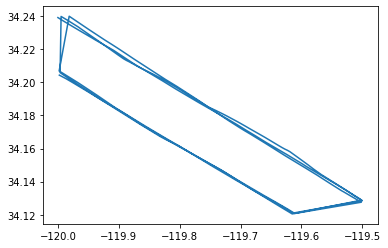

In [11]:
oneVessel = "../Data/M120_00_M190_50_34_12_34_24/MMSI/566952000_Sorted.csv"
oneVesselData,_ = aISDM.load_data_from_csv(oneVessel)
print(oneVesselData.shape)
oneVesselLon = oneVesselData['LON']
oneVesselLat = oneVesselData['LAT']
plt.plot(oneVesselLon,oneVesselLat)

In [12]:
oneVesselTime = oneVesselData['DateTime']
for i in range(oneVesselLon.shape[0]):
    print(oneVesselTime[i])

2017-01-02 02:04:50
2017-01-02 02:06:01
2017-01-02 02:07:11
2017-01-02 02:08:20
2017-01-02 02:09:30
2017-01-02 02:10:41
2017-01-02 02:11:50
2017-01-02 02:13:00
2017-01-02 02:14:11
2017-01-02 02:15:20
2017-01-02 02:16:21
2017-01-02 02:17:31
2017-01-02 02:18:40
2017-01-02 02:19:50
2017-01-02 02:21:00
2017-01-02 02:22:10
2017-01-02 02:23:20
2017-01-02 02:24:30
2017-01-02 02:25:41
2017-01-02 02:26:51
2017-01-02 02:28:01
2017-01-02 02:29:09
2017-01-02 02:30:20
2017-01-02 02:31:30
2017-01-02 02:32:40
2017-01-02 02:33:50
2017-01-02 02:35:00
2017-01-02 02:36:10
2017-01-02 02:37:20
2017-01-02 02:38:31
2017-01-02 02:39:40
2017-01-02 02:40:50
2017-01-02 02:41:51
2017-01-02 02:43:00
2017-01-02 02:44:10
2017-01-02 02:45:21
2017-01-02 02:46:31
2017-01-02 02:47:40
2017-01-02 02:48:50
2017-01-02 02:50:01
2017-01-02 02:51:11
2017-01-02 02:52:20
2017-01-02 02:53:21
2017-01-02 02:54:30
2017-01-02 02:55:41
2017-01-02 02:56:51
2017-01-02 02:58:01
2017-01-02 02:59:10
2017-01-02 03:00:21
2017-01-02 03:01:31


In [13]:
timeIntervalList = "../Data/M120_00_M190_50_34_12_34_24/TimeInterval/HalfHourIntvl1701To1702.txt"
timeWindows = [line.rstrip('\n') for line in open(timeIntervalList)]

In [14]:
#get the last instance of the position data 
#for one of the vessel
#and that can be used for the prediction
oneVesselLastData = pd.DataFrame()
#based on time stamps 
for timeSlot in timeWindows:
    temp = timeSlot.split(',')
    startTime = temp[0]
    endTime = temp[1]

    timelyDF = aISDM.filter_based_on_time_stamp(oneVesselData,'DateTime',startTime,endTime)
    oneVesselRows = timelyDF.shape[0]
    
    invertedTimelyDF = aISDM.inver_df(timelyDF)
    invertedTimelyDF = invertedTimelyDF.drop_duplicates(subset="MMSI")
    
    oneVesselLastData = oneVesselLastData.append(invertedTimelyDF, ignore_index = True)

In [15]:
print(oneVesselLastData)

         MMSI         BaseDateTime       LAT        LON  SOG    COG  Heading  \
0   566952000  2017-01-02T02:29:09  34.18704 -119.91849  9.7  105.2    101.0   
1   566952000  2017-01-02T02:59:10  34.16577 -119.82437  9.6  102.8    100.0   
2   566952000  2017-01-02T03:29:10  34.14665 -119.73032  9.7  105.2    104.0   
3   566952000  2017-01-02T03:59:01  34.12650 -119.63697  9.7  104.4    104.0   
4   566952000  2017-01-02T04:07:10  34.12079 -119.61099  9.8  105.2    105.0   
5   566952000  2017-01-05T22:59:50  34.13857 -119.54273  6.2 -123.3    282.0   
6   566952000  2017-01-05T23:29:51  34.15269 -119.59874  5.5 -121.9    280.0   
7   566952000  2017-01-05T23:59:59  34.16530 -119.65319  5.6 -124.3    280.0   
8   566952000  2017-01-06T00:28:50  34.17661 -119.70700  5.7 -126.5    280.0   
9   566952000  2017-01-06T00:59:09  34.18780 -119.76462  5.6 -123.7    285.0   
10  566952000  2017-01-06T01:29:29  34.20048 -119.82097  6.0 -125.3    285.0   
11  566952000  2017-01-06T01:59:20  34.2

In [16]:
#divide the journey into two parts
#part 1 is from 0 to 4 included
#part 2 is from 5 to 13 included
oneVesselLastDataOne = oneVesselLastData.iloc[0:5,:]
oneVesselLastDataTwo = oneVesselLastData.iloc[5:,:]

# oneVesselLastDataOne = oneVesselLastData.iloc[0:4,:]

In [17]:
print(oneVesselLastDataOne)

        MMSI         BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  566952000  2017-01-02T02:29:09  34.18704 -119.91849  9.7  105.2    101.0   
1  566952000  2017-01-02T02:59:10  34.16577 -119.82437  9.6  102.8    100.0   
2  566952000  2017-01-02T03:29:10  34.14665 -119.73032  9.7  105.2    104.0   
3  566952000  2017-01-02T03:59:01  34.12650 -119.63697  9.7  104.4    104.0   
4  566952000  2017-01-02T04:07:10  34.12079 -119.61099  9.8  105.2    105.0   

     VesselName         IMO CallSign  VesselType                  Status  \
0  APL SAVANNAH  IMO9597513   9V9919      1004.0  under way using engine   
1  APL SAVANNAH  IMO9597513   9V9919      1004.0  under way using engine   
2  APL SAVANNAH  IMO9597513   9V9919      1004.0  under way using engine   
3  APL SAVANNAH  IMO9597513   9V9919      1004.0  under way using engine   
4  APL SAVANNAH  IMO9597513   9V9919      1004.0  under way using engine   

   Length  Width  Draft  Cargo            DateTime  
0   328.2   45.

In [18]:
print(oneVesselLastDataTwo)

         MMSI         BaseDateTime       LAT        LON  SOG    COG  Heading  \
5   566952000  2017-01-05T22:59:50  34.13857 -119.54273  6.2 -123.3    282.0   
6   566952000  2017-01-05T23:29:51  34.15269 -119.59874  5.5 -121.9    280.0   
7   566952000  2017-01-05T23:59:59  34.16530 -119.65319  5.6 -124.3    280.0   
8   566952000  2017-01-06T00:28:50  34.17661 -119.70700  5.7 -126.5    280.0   
9   566952000  2017-01-06T00:59:09  34.18780 -119.76462  5.6 -123.7    285.0   
10  566952000  2017-01-06T01:29:29  34.20048 -119.82097  6.0 -125.3    285.0   
11  566952000  2017-01-06T01:59:20  34.21193 -119.88023  6.3 -126.7    288.0   
12  566952000  2017-01-06T02:29:09  34.22696 -119.94099  6.3 -122.7    291.0   
13  566952000  2017-01-06T02:55:39  34.23985 -119.99474  6.1 -125.1    289.0   

      VesselName         IMO CallSign  VesselType                  Status  \
5   APL SAVANNAH  IMO9597513   9V9919      1004.0  under way using engine   
6   APL SAVANNAH  IMO9597513   9V9919      10

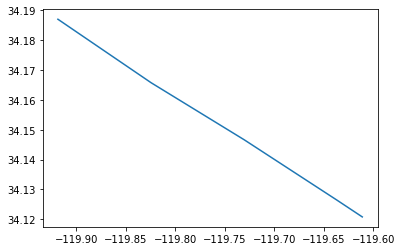

In [19]:
oneVesselLastDataOneLon = oneVesselLastDataOne["LON"]
oneVesselLastDataOneLat = oneVesselLastDataOne["LAT"]
plt.plot(oneVesselLastDataOneLon,oneVesselLastDataOneLat)

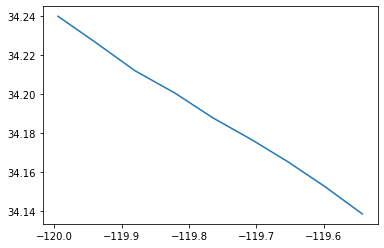

In [20]:
oneVesselLastDataTwoLon = oneVesselLastDataTwo["LON"]
oneVesselLastDataTwoLat = oneVesselLastDataTwo["LAT"]
plt.plot(oneVesselLastDataTwoLon,oneVesselLastDataTwoLat)

In [21]:
vesselPrevState = get_vessel_init_status(oneVesselLastDataOneLon.iloc[0],oneVesselLastDataOneLat.iloc[0])
vesselCurrState = get_vessel_init_status(oneVesselLastDataOneLon.iloc[1],oneVesselLastDataOneLat.iloc[1])
vesselState = generate_vessel_prev_cur_status(vesselPrevState,vesselCurrState)
onePredict = []
for i in range(3):
    vesselProbState = generate_path(vesselState)
    onePredict.append(vesselProbState.copy())
    vesselPrevState = vesselCurrState.copy()
    vesselCurrState = vesselProbState.copy()
    vesselState = generate_vessel_prev_cur_status(vesselPrevState,vesselCurrState)

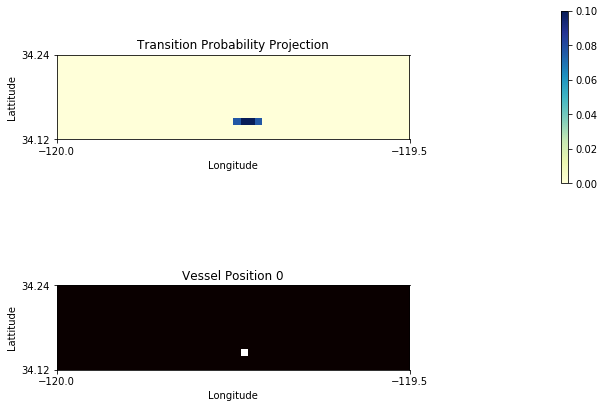

In [22]:
vesselPrevState = get_vessel_init_status(oneVesselLastDataOneLon.iloc[0],oneVesselLastDataOneLat.iloc[0])
vesselCurrState = get_vessel_init_status(oneVesselLastDataOneLon.iloc[1],oneVesselLastDataOneLat.iloc[1])
vesselState = generate_vessel_prev_cur_status(vesselPrevState,vesselCurrState)
useAspect = 0
aspectRatio = 16.0/9.0
figWidth = 10
figHeight = 8

fig = plt.figure(figsize=(figWidth,figHeight))
ax1 = fig.add_axes([0.1, 0.15, 0.49, 0.30])
ax2 = fig.add_axes([0.1, 0.55, 0.49, 0.30])
ax4 = fig.add_axes([0.8, 0.55, 0.01, 0.30])

if useAspect == 1:
    figHeight = figWidth/aspectRatio

def animate(i):
    global vesselPrevState, vesselCurrState, vesselState
    vesselCurrPos = get_vessel_init_status(oneVesselLastDataOneLon.iloc[i+2],oneVesselLastDataOneLat.iloc[i+2])
    vesselCurrPos = np.reshape(vesselCurrPos,(verticalAxis.shape[0],horizontalAxis.shape[0]))
    
    vesselCurrPos = np.flip(vesselCurrPos,axis=0)

    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Lattitude')
    titleStr = 'Vessel Position %d'%((i))
    ax1.set_title(titleStr)
    ax1.set_xticks([lonMin,lonMax])
    ax1.set_yticks([latMin,latMax])

    ax2.set_xlabel('Longitude')
    ax2.set_ylabel('Lattitude')
    ax2.set_title('Transition Probability Projection')
    ax2.set_xticks([lonMin,lonMax])
    ax2.set_yticks([latMin,latMax])

    ax1.imshow(vesselCurrPos,cmap=plt.get_cmap('hot'),extent=[lonMin,lonMax,latMin,latMax])
    #sequence of vessel states
#     vesselProbState = generate_path(vesselState)
#     #copy the file
#     vesselPrevState = vesselCurrState.copy()
#     vesselCurrState = vesselProbState.copy()
#     vesselState = generate_vessel_prev_cur_status(vesselPrevState,vesselCurrState)
    
    vesselProbState = onePredict[i].copy()
    vesselProbState = np.reshape(vesselProbState,(verticalAxis.shape[0],horizontalAxis.shape[0]))
    vesselProbState = np.flip(vesselProbState,axis=0)
    iMShowHandler = ax2.imshow(vesselProbState,cmap=plt.get_cmap('YlGnBu'),extent=[lonMin,lonMax,latMin,latMax], vmax = 0.10)
    
    fig.colorbar(iMShowHandler,ax4)
    
anim = animation.FuncAnimation(fig, animate,frames=3, interval=1000)

In [23]:
HTML(anim.to_html5_video())

In [24]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=1, metadata=dict(artist='Me'), bitrate=1800)

In [ ]:
anim.save('TPSeqOneSecOrder.mp4', writer=writer)

In [25]:
vesselPrevState = get_vessel_init_status(oneVesselLastDataTwoLon.iloc[0],oneVesselLastDataTwoLat.iloc[0])
vesselCurrState = get_vessel_init_status(oneVesselLastDataTwoLon.iloc[1],oneVesselLastDataTwoLat.iloc[1])
vesselState = generate_vessel_prev_cur_status(vesselPrevState,vesselCurrState)
twoPredict = []
for i in range(7):
    vesselProbState = generate_path(vesselState)
    twoPredict.append(vesselProbState.copy())
    vesselPrevState = vesselCurrState.copy()
    vesselCurrState = vesselProbState.copy()
    vesselState = generate_vessel_prev_cur_status(vesselPrevState,vesselCurrState)

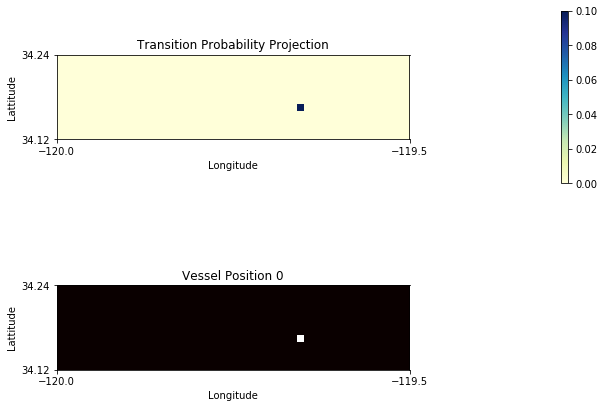

In [26]:
vesselPrevState = get_vessel_init_status(oneVesselLastDataTwoLon.iloc[0],oneVesselLastDataTwoLat.iloc[0])
vesselCurrState = get_vessel_init_status(oneVesselLastDataTwoLon.iloc[1],oneVesselLastDataTwoLat.iloc[1])
vesselState = generate_vessel_prev_cur_status(vesselPrevState,vesselCurrState)

useAspect = 0
aspectRatio = 16.0/9.0
figWidth = 10
figHeight = 8

fig = plt.figure(figsize=(figWidth,figHeight))
ax1 = fig.add_axes([0.1, 0.15, 0.49, 0.30])
ax2 = fig.add_axes([0.1, 0.55, 0.49, 0.30])
ax4 = fig.add_axes([0.8, 0.55, 0.01, 0.30])

if useAspect == 1:
    figHeight = figWidth/aspectRatio

def animate(i):
    global vesselPrevState, vesselCurrState, vesselState
    vesselCurrPos = get_vessel_init_status(oneVesselLastDataTwoLon.iloc[i+2],oneVesselLastDataTwoLat.iloc[i+2])
    vesselCurrPos = np.reshape(vesselCurrPos,(verticalAxis.shape[0],horizontalAxis.shape[0]))
    
    vesselCurrPos = np.flip(vesselCurrPos,axis=0)

    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Lattitude')
    titleStr = 'Vessel Position %d'%((i))
    ax1.set_title(titleStr)
    ax1.set_xticks([lonMin,lonMax])
    ax1.set_yticks([latMin,latMax])

    ax2.set_xlabel('Longitude')
    ax2.set_ylabel('Lattitude')
    ax2.set_title('Transition Probability Projection')
    ax2.set_xticks([lonMin,lonMax])
    ax2.set_yticks([latMin,latMax])

    ax1.imshow(vesselCurrPos,cmap=plt.get_cmap('hot'),extent=[lonMin,lonMax,latMin,latMax])
    #sequence of vessel states
    
    vesselProbState = twoPredict[i].copy()
    vesselProbState = np.reshape(vesselProbState,(verticalAxis.shape[0],horizontalAxis.shape[0]))
    vesselProbState = np.flip(vesselProbState,axis=0)
    
    iMShowHandler = ax2.imshow(vesselProbState,cmap=plt.get_cmap('YlGnBu'),extent=[lonMin,lonMax,latMin,latMax], vmax = 0.10)
    
    fig.colorbar(iMShowHandler,ax4)
    
anim = animation.FuncAnimation(fig, animate,frames=7, interval=1000)

In [27]:
HTML(anim.to_html5_video())

In [ ]:
anim.save('TPSeqTwoSecOrder.mp4', writer=writer)